# EDA

## Import libraries and load data

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

I take the data from NY Taxi and Limousine Commission (TLC) [website](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page). The data is for year 2023.

Data can easy be downloaded in parquet format and directly loaded into pandas dataframe, but wee need to load it for each month separately.

https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet  
https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-02.parquet  
...

We could also download the data using curl command in bash:

```bash
for month in {01..12}; do
  curl -O https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-$month.parquet
done
```

In [44]:
base_url = "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-"

# Initialize an empty DataFrame
df = pd.DataFrame()

for item in range(1, 13):
    url = base_url + str(item).zfill(2) + ".parquet"

    # read the data
    print(f"Ingesting {url.split('/')[-1]}")
    df_single_month = pd.read_parquet(url)

    # concatenate the data
    df = pd.concat([df, df_single_month], axis=0)

Ingesting green_tripdata_2023-01.parquet
Ingesting green_tripdata_2023-02.parquet
Ingesting green_tripdata_2023-03.parquet
Ingesting green_tripdata_2023-04.parquet
Ingesting green_tripdata_2023-05.parquet
Ingesting green_tripdata_2023-06.parquet
Ingesting green_tripdata_2023-07.parquet
Ingesting green_tripdata_2023-08.parquet
Ingesting green_tripdata_2023-09.parquet
Ingesting green_tripdata_2023-10.parquet
Ingesting green_tripdata_2023-11.parquet
Ingesting green_tripdata_2023-12.parquet


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 787060 entries, 0 to 64214
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               787060 non-null  int64         
 1   lpep_pickup_datetime   787060 non-null  datetime64[us]
 2   lpep_dropoff_datetime  787060 non-null  datetime64[us]
 3   store_and_fwd_flag     731447 non-null  object        
 4   RatecodeID             731447 non-null  float64       
 5   PULocationID           787060 non-null  int64         
 6   DOLocationID           787060 non-null  int64         
 7   passenger_count        731447 non-null  float64       
 8   trip_distance          787060 non-null  float64       
 9   fare_amount            787060 non-null  float64       
 10  extra                  787060 non-null  float64       
 11  mta_tax                787060 non-null  float64       
 12  tip_amount             787060 non-null  float64   

A detailed description of the data fields can be found in the [docs folder](../docs/data_dictionary_trip_records_green.pdf)

we also need the Taxi Zone Lookup Table

https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv

In [46]:
df_lookup = pd.read_csv(
    "https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv"
)
df_lookup.info(), df_lookup.head(), df_lookup.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   LocationID    265 non-null    int64 
 1   Borough       264 non-null    object
 2   Zone          264 non-null    object
 3   service_zone  263 non-null    object
dtypes: int64(1), object(3)
memory usage: 8.4+ KB


(None,
    LocationID        Borough                     Zone service_zone
 0           1            EWR           Newark Airport          EWR
 1           2         Queens              Jamaica Bay    Boro Zone
 2           3          Bronx  Allerton/Pelham Gardens    Boro Zone
 3           4      Manhattan            Alphabet City  Yellow Zone
 4           5  Staten Island            Arden Heights    Boro Zone,
      LocationID    Borough                Zone service_zone
 260         261  Manhattan  World Trade Center  Yellow Zone
 261         262  Manhattan      Yorkville East  Yellow Zone
 262         263  Manhattan      Yorkville West  Yellow Zone
 263         264    Unknown                 NaN          NaN
 264         265        NaN      Outside of NYC          NaN)

In [47]:
# Merge the data

df = df.merge(
    df_lookup,
    left_on="PULocationID",
    right_on="LocationID",
    how="left"
)
df = df.merge(
    df_lookup,
    left_on="DOLocationID",
    right_on="LocationID",
    how="left",
    suffixes=("_PU", "_DO"),
)
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,trip_type,congestion_surcharge,LocationID_PU,Borough_PU,Zone_PU,service_zone_PU,LocationID_DO,Borough_DO,Zone_DO,service_zone_DO
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,1.0,166,143,1.0,2.58,14.9,...,1.0,2.75,166,Manhattan,Morningside Heights,Boro Zone,143,Manhattan,Lincoln Square West,Yellow Zone
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,1.0,24,43,1.0,1.81,10.7,...,1.0,0.00,24,Manhattan,Bloomingdale,Yellow Zone,43,Manhattan,Central Park,Yellow Zone
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,1.0,223,179,1.0,0.00,7.2,...,1.0,0.00,223,Queens,Steinway,Boro Zone,179,Queens,Old Astoria,Boro Zone
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,1.0,41,238,1.0,1.30,6.5,...,1.0,0.00,41,Manhattan,Central Harlem,Boro Zone,238,Manhattan,Upper West Side North,Yellow Zone
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,1.0,41,74,1.0,1.10,6.0,...,1.0,0.00,41,Manhattan,Central Harlem,Boro Zone,74,Manhattan,East Harlem North,Boro Zone


In [48]:
# drop 'LocationID_PU' and 'LocationID_DO' columns

df.drop(columns=["LocationID_PU", "LocationID_DO"], inplace=True)

df.columns

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge',
       'Borough_PU', 'Zone_PU', 'service_zone_PU', 'Borough_DO', 'Zone_DO',
       'service_zone_DO'],
      dtype='object')

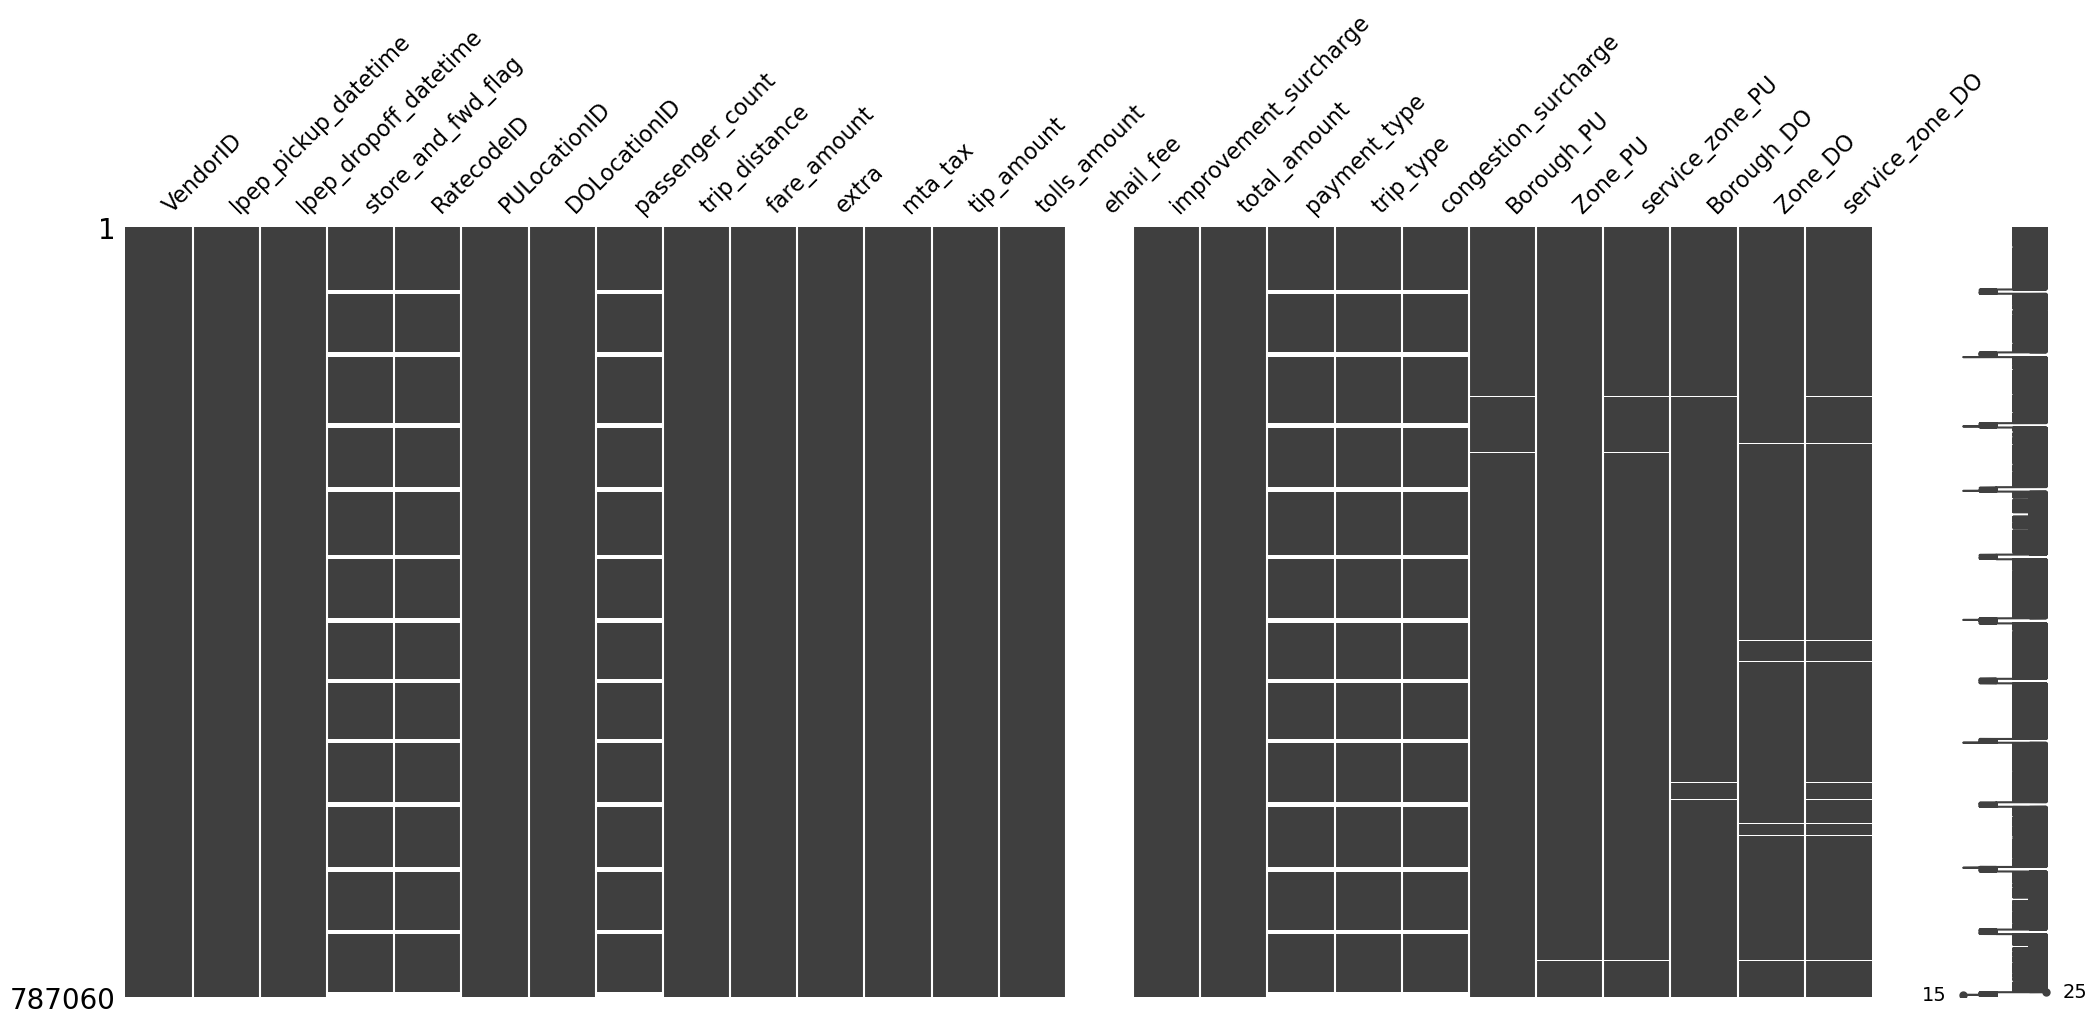

In [49]:
import missingno as msno

msno.matrix(df);

In [39]:
# count missing values
missing_values = df.isnull().sum()
missing_values

VendorID                      0
lpep_pickup_datetime          0
lpep_dropoff_datetime         0
store_and_fwd_flag        55613
RatecodeID                55613
PULocationID                  0
DOLocationID                  0
passenger_count           55613
trip_distance                 0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
ehail_fee                787060
improvement_surcharge         0
total_amount                  0
payment_type              55613
trip_type                 55658
congestion_surcharge      55613
Borough_PU                  736
Zone_PU                    1524
service_zone_PU            2260
Borough_DO                 3333
Zone_DO                    5707
service_zone_DO            9040
dtype: int64

In [40]:
# drop rows with missing values
df.dropna(inplace=True)
missing_values2 = df.isnull().sum()
missing_values2

VendorID                 0
lpep_pickup_datetime     0
lpep_dropoff_datetime    0
store_and_fwd_flag       0
RatecodeID               0
PULocationID             0
DOLocationID             0
passenger_count          0
trip_distance            0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
ehail_fee                0
improvement_surcharge    0
total_amount             0
payment_type             0
trip_type                0
congestion_surcharge     0
Borough_PU               0
Zone_PU                  0
service_zone_PU          0
Borough_DO               0
Zone_DO                  0
service_zone_DO          0
dtype: int64

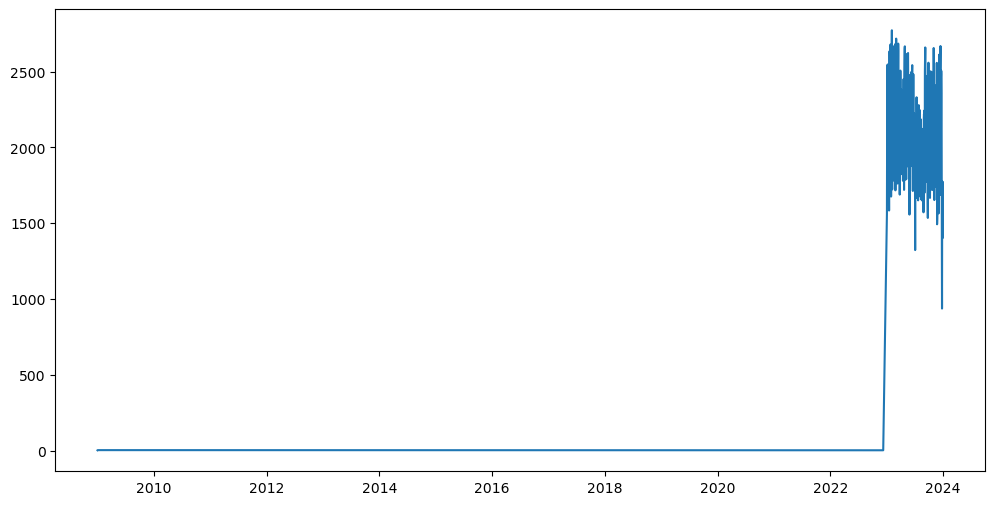

In [50]:
# plot trips per day as line chart
df["date"] = df["lpep_pickup_datetime"].dt.date

trips_per_day = df["date"].value_counts().sort_index()
plt.figure(figsize=(12, 6))
plt.plot(trips_per_day)

In [51]:
# remove outliers before 2023

df = df[df["lpep_pickup_datetime"].dt.year == 2023]

## Is there a trend in the daily number of trips?

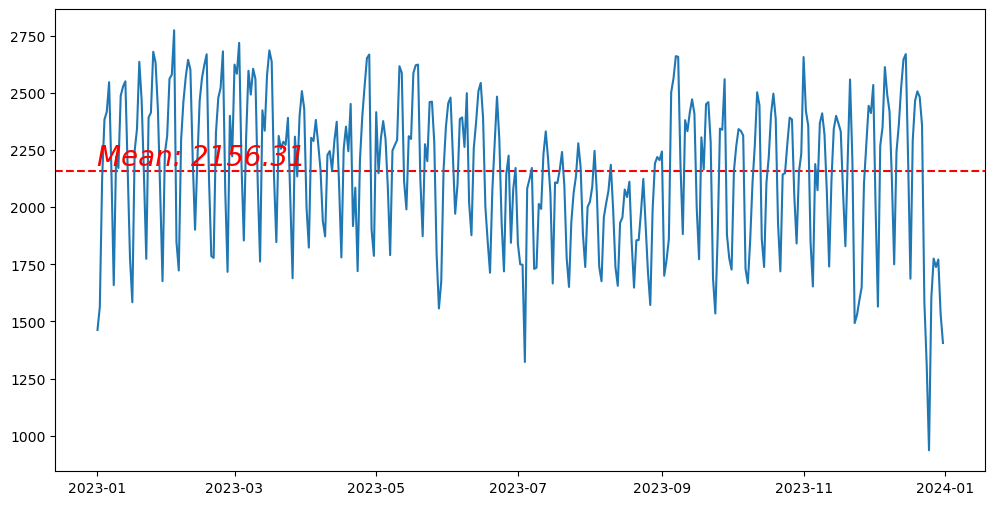

In [64]:
trips_per_day = df["date"].value_counts().sort_index()
plt.figure(figsize=(12, 6))
# add red line for mean and annotation in large bold font, 10 points above the mean
plt.axhline(trips_per_day.mean(), color="red", linestyle="--")
plt.text(
    trips_per_day.index[0],
    trips_per_day.mean(),
    f"Mean: {trips_per_day.mean():.2f}",
    color="red",
    fontsize=20,
    va="bottom",
    style="oblique",
)

plt.plot(trips_per_day);

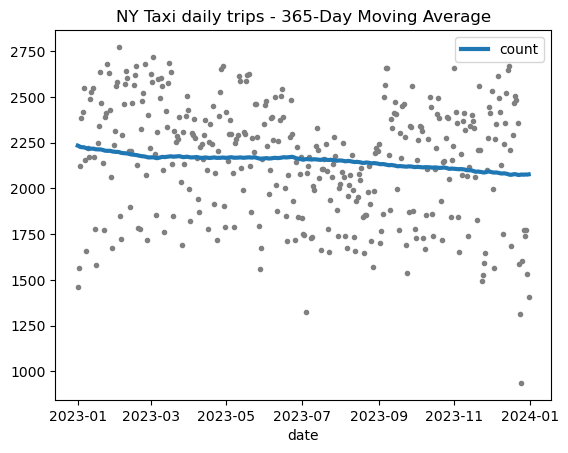

In [67]:
moving_average = trips_per_day.rolling(
    window=365,  # 365-day window
    center=True,  # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()  # compute the mean (could also do median, std, min, max, ...)

ax = trips_per_day.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax,
    linewidth=3,
    title="NY Taxi daily trips - 365-Day Moving Average",
    legend=True,
);

In [68]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=trips_per_day.index,  # dates from the training data
    constant=True,  # dummy feature for the bias (y_intercept)
    order=1,  # the time dummy (trend)
    drop=True,  # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend
date,,
2023-01-01,1.0,1.0
2023-01-02,1.0,2.0
2023-01-03,1.0,3.0
2023-01-04,1.0,4.0
2023-01-05,1.0,5.0


In [69]:
from sklearn.linear_model import LinearRegression

y = trips_per_day  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

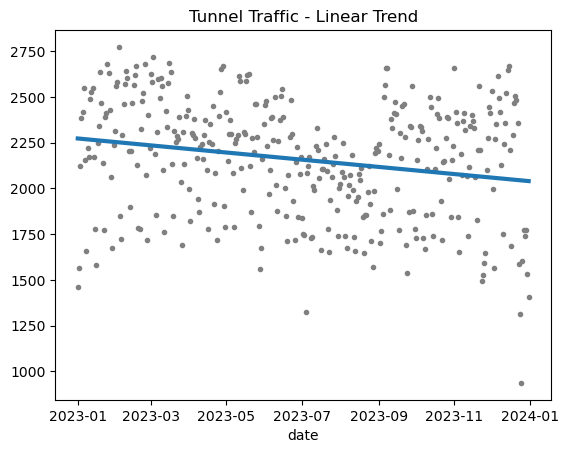

In [70]:
ax = trips_per_day.plot(style=".", color="0.5", title="Tunnel Traffic - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

### Forecast

In [71]:
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()


/opt/homebrew/Caskroom/miniforge/base/envs/NYTaxi_forecast/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


366    2039.225771
367    2038.585969
368    2037.946167
369    2037.306365
370    2036.666562
dtype: float64

In [74]:
trips_per_day.head()

date
2023-01-01    1463
2023-01-02    1564
2023-01-03    2125
2023-01-04    2383
2023-01-05    2417
Name: count, dtype: int64

In [77]:
y_pred.tail()

date
2023-12-27    2042.424783
2023-12-28    2041.784981
2023-12-29    2041.145178
2023-12-30    2040.505376
2023-12-31    2039.865574
dtype: float64

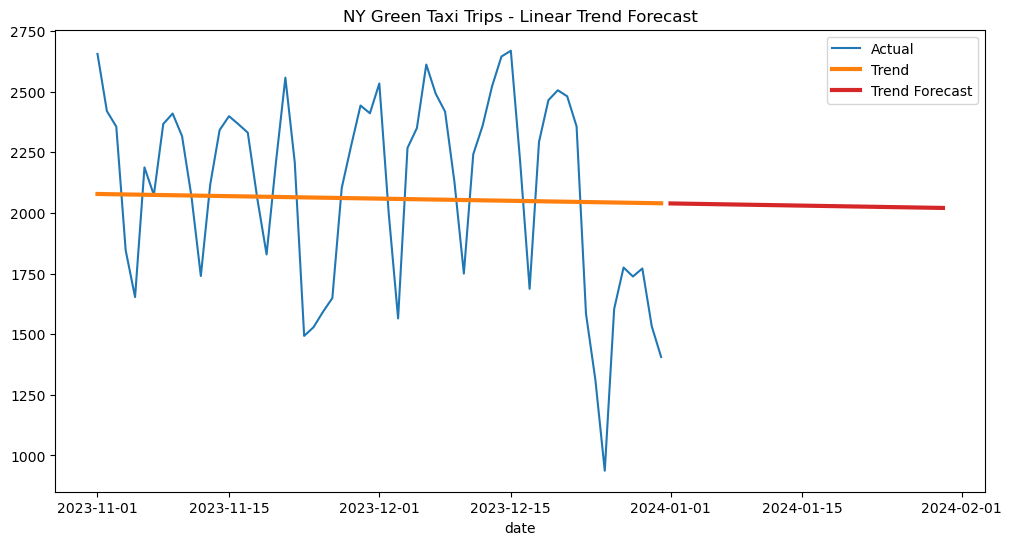

In [81]:
# Get the last date from trips_per_day
last_date = pd.to_datetime("2023-12-31").date()

# Create new dates for forecast starting from January 1, 2024
forecast_dates = pd.date_range(start="2024-01-01", periods=30, freq='D').date

# Convert forecast to a Series with proper dates
y_fore = pd.Series(y_fore.values, index=forecast_dates)

# Plot with adjusted dates
start_date = pd.to_datetime("2023-11-01").date()

ax = trips_per_day[trips_per_day.index >= start_date].plot(
    title="NY Green Taxi Trips - Linear Trend Forecast",
    figsize=(12, 6),
    label="Actual"
)
ax = y_pred[y_pred.index >= start_date].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()